<a href="https://colab.research.google.com/github/poojanpatelalpesh/SimCLR/blob/main/SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
class SimCLRAugmentation:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply(
                [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
            transforms.ToTensor()
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)


In [ ]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=SimCLRAugmentation()
)

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=2,
    drop_last=True
)


100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

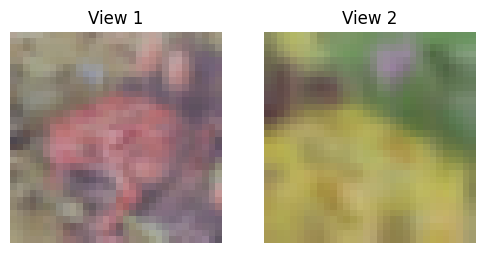

In [ ]:
x, _ = next(iter(train_loader))
img1, img2 = x

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(img1[0].permute(1,2,0))
plt.title("View 1")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img2[0].permute(1,2,0))
plt.title("View 2")
plt.axis("off")


PHASE-2

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = resnet18(pretrained=False)
        self.backbone.fc = nn.Identity()  # remove classifier

    def forward(self, x):
        return self.backbone(x)


In [ ]:
class ProjectionHead(nn.Module):
    def __init__(self, in_dim=512, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(),
            nn.Linear(in_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class SimCLR(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.projector = ProjectionHead()

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return F.normalize(z, dim=1)


In [ ]:
model = SimCLR().to(device)

x, _ = next(iter(train_loader))
x1, x2 = x
x1 = x1.to(device)

z = model(x1)
z.shape


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


torch.Size([256, 128])

In [ ]:
#NT-Xent Loss Implementation
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        N = z1.size(0)

        z = torch.cat([z1, z2], dim=0)   # [2N, D]
        sim = torch.matmul(z, z.T)       # similarity matrix
        sim /= self.temperature

        # mask self-similarity
        mask = torch.eye(2*N, device=z.device).bool()
        sim.masked_fill_(mask, -9e15)

        # positive similarities
        pos = torch.sum(z1 * z2, dim=1) / self.temperature
        pos = torch.cat([pos, pos], dim=0)

        loss = -pos + torch.logsumexp(sim, dim=1)
        return loss.mean()


In [ ]:
criterion = NTXentLoss()

x, _ = next(iter(train_loader))
x1, x2 = x
x1, x2 = x1.to(device), x2.to(device)

z1 = model(x1)
z2 = model(x2)

loss = criterion(z1, z2)
loss


tensor(6.1883, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
criterion = NTXentLoss(temperature=0.5)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-6
)


In [ ]:
def train_simclr(model, loader, criterion, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        total_loss = 0

        for (x, _) in loader:
            x1, x2 = x
            x1 = x1.to(device)
            x2 = x2.to(device)

            z1 = model(x1)
            z2 = model(x2)

            loss = criterion(z1, z2)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f}")


In [ ]:
train_simclr(
    model=model,
    loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=10
)


Epoch [1/10] | Loss: 5.3953
Epoch [2/10] | Loss: 5.2035
Epoch [3/10] | Loss: 5.1309
Epoch [4/10] | Loss: 5.0910
Epoch [5/10] | Loss: 5.0608
Epoch [6/10] | Loss: 5.0384
Epoch [7/10] | Loss: 5.0156
Epoch [8/10] | Loss: 4.9981
Epoch [9/10] | Loss: 4.9827
Epoch [10/10] | Loss: 4.9670


In [ ]:
# freeze encoder
for param in model.encoder.backbone.parameters():
    param.requires_grad = False


In [ ]:
# print(model)

In [ ]:
linear_classifier = torch.nn.Linear(512, 10).to(device)


In [ ]:
criterion_cls = torch.nn.CrossEntropyLoss()

optimizer_cls = torch.optim.Adam(
    linear_classifier.parameters(),
    lr=1e-3
)


In [ ]:
def extract_features(backbone, loader):
    backbone.eval()
    features = []
    labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            feat = backbone(x)     # ResNet output (512)
            features.append(feat.cpu())
            labels.append(y)

    return torch.cat(features), torch.cat(labels)


In [ ]:
from torchvision.datasets import CIFAR10
from torchvision import transforms

# transform for linear evaluation (single image)
linear_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# datasets for linear probing
train_linear = CIFAR10(
    root="./data",
    train=True,
    transform=linear_transform,
    download=False
)

test_linear = CIFAR10(
    root="./data",
    train=False,
    transform=linear_transform,
    download=False
)


In [ ]:
train_linear_loader = torch.utils.data.DataLoader(
    train_linear,
    batch_size=256,
    shuffle=True,
    num_workers=0
)

test_linear_loader = torch.utils.data.DataLoader(
    test_linear,
    batch_size=256,
    shuffle=False,
    num_workers=0
)


In [ ]:
train_feats, train_labels = extract_features(
    model.encoder.backbone, train_linear_loader
)

test_feats, test_labels = extract_features(
    model.encoder.backbone, test_linear_loader
)

print(train_feats.shape, test_feats.shape)


torch.Size([50000, 512]) torch.Size([10000, 512])


In [ ]:
linear_classifier.train()

for epoch in range(20):
    optimizer_cls.zero_grad()

    outputs = linear_classifier(train_feats.to(device))
    loss = criterion_cls(outputs, train_labels.to(device))

    loss.backward()
    optimizer_cls.step()

    acc = (outputs.argmax(1) == train_labels.to(device)).float().mean()
    print(f"Epoch {epoch+1:02d} | Loss {loss.item():.4f} | Acc {acc.item()*100:.2f}%")



Epoch 01 | Loss 2.5641 | Acc 6.03%
Epoch 02 | Loss 2.3726 | Acc 8.00%
Epoch 03 | Loss 2.3121 | Acc 11.31%
Epoch 04 | Loss 2.2996 | Acc 14.57%
Epoch 05 | Loss 2.2795 | Acc 16.72%
Epoch 06 | Loss 2.2421 | Acc 18.42%
Epoch 07 | Loss 2.1965 | Acc 20.44%
Epoch 08 | Loss 2.1538 | Acc 20.70%
Epoch 09 | Loss 2.1202 | Acc 21.02%
Epoch 10 | Loss 2.0984 | Acc 22.16%
Epoch 11 | Loss 2.0850 | Acc 22.31%
Epoch 12 | Loss 2.0734 | Acc 22.93%
Epoch 13 | Loss 2.0596 | Acc 24.02%
Epoch 14 | Loss 2.0440 | Acc 24.25%
Epoch 15 | Loss 2.0291 | Acc 24.19%
Epoch 16 | Loss 2.0171 | Acc 24.41%
Epoch 17 | Loss 2.0082 | Acc 25.00%
Epoch 18 | Loss 2.0011 | Acc 24.90%
Epoch 19 | Loss 1.9944 | Acc 24.70%
Epoch 20 | Loss 1.9875 | Acc 24.74%


In [ ]:
linear_classifier.eval()

with torch.no_grad():
    outputs = linear_classifier(test_feats.to(device))
    acc = (outputs.argmax(1) == test_labels.to(device)).float().mean()

print(f"Test Accuracy: {acc.item()*100:.2f}%")


Test Accuracy: 24.93%
